# Compare Levmar vs GSL engines (sinh, only sim09_r.fits)

In [1]:
%matplotlib inline
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import prettyprint
import re
import numpy as np
from glob import glob
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection
from matplotlib.gridspec import GridSpec
from stuff import Simulation
from validation import CrossValidation
from image import Image

## Model configuration

In [2]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/sim09/sim09.config')

In [3]:
prettyprint.prettyprint('/home/aalvarez/Work/Data/sim09/sim09_r_model.py')

**Note:** `set_engine('gsl')` is commented out when running using Levmar

In [4]:
base_dir = '/home/aalvarez/Work/Data/sim09/'
frames = sorted(glob(os.path.join(base_dir, 'sim09_r_*.fits')))
nframes = len(frames)
print(f'Number of frames used: {nframes}')

Number of frames used: 10


## Levmar run

In [5]:
levmar_dir = '/home/aalvarez/Work/Data/sim09/sim09_r_levmar/'
levmar_log = open(os.path.join(levmar_dir, 'sim09.log')).read()

In [6]:
rengine = re.search('Using engine \w+', levmar_log)
levmar_log[rengine.start():rengine.end()]

'Using engine levmar'

In [7]:
re.findall('Elapsed: \d+:\d+:\d+', levmar_log)[-1]

'Elapsed: 00:03:24'

In [8]:
cmap = plt.get_cmap('Greys')
norm = colors.SymLogNorm(1)

ncols = 2
nrows = int(nframes / ncols)

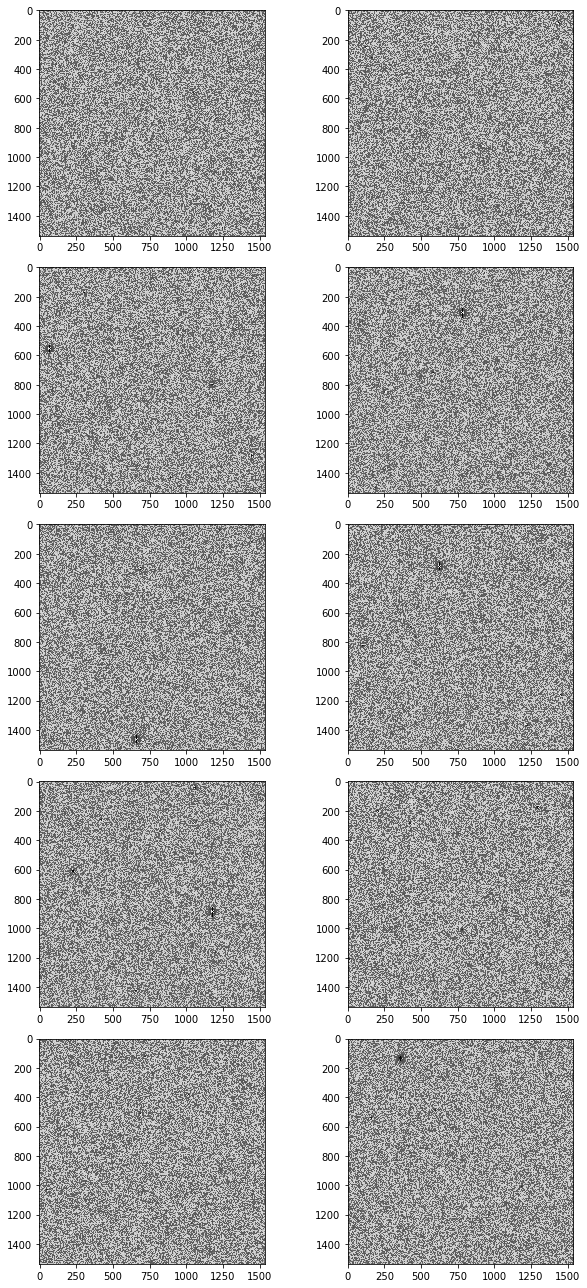

In [9]:
fig, axs = plt.subplots(nrows, ncols, figsize=(9,18))

for i in range(nframes):
    frame_data = fits.open(os.path.join(levmar_dir, f'_residual_{i}.fits'))[0].data
    axs[int(i / 2), int(i % 2)].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## GSL run

In [10]:
gsl_dir = '/home/aalvarez/Work/Data/sim09/sim09_r_gsl/'
gsl_log = open(os.path.join(gsl_dir, 'sim09.log')).read()

In [11]:
rengine = re.search('Using engine \w+', gsl_log)
gsl_log[rengine.start():rengine.end()]

'Using engine gsl'

In [12]:
re.findall('Elapsed: \d+:\d+:\d+', gsl_log)[-1]

'Elapsed: 00:06:33'

First approach takes longer. May be possible to play with the parameters?

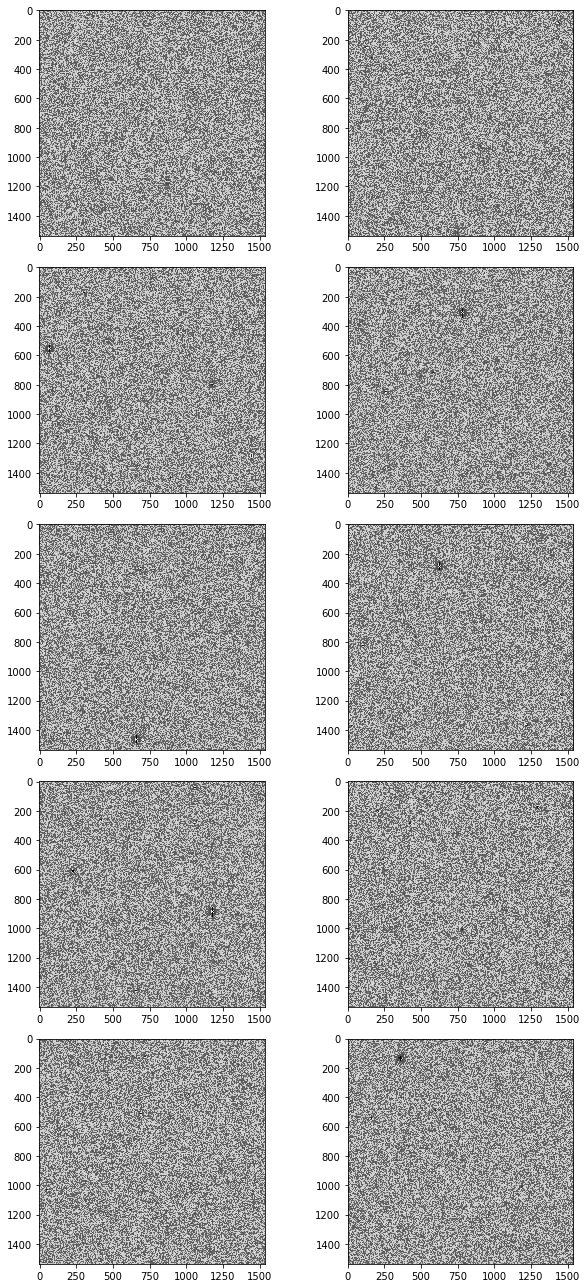

In [13]:
fig, axs = plt.subplots(nrows, ncols, figsize=(9,18))

for i in range(nframes):
    frame_data = fits.open(os.path.join(gsl_dir, f'_residual_{i}.fits'))[0].data
    axs[int(i / 2), int(i % 2)].imshow(frame_data, cmap=cmap, norm=norm)

plt.tight_layout()
plt.show()

## Compare

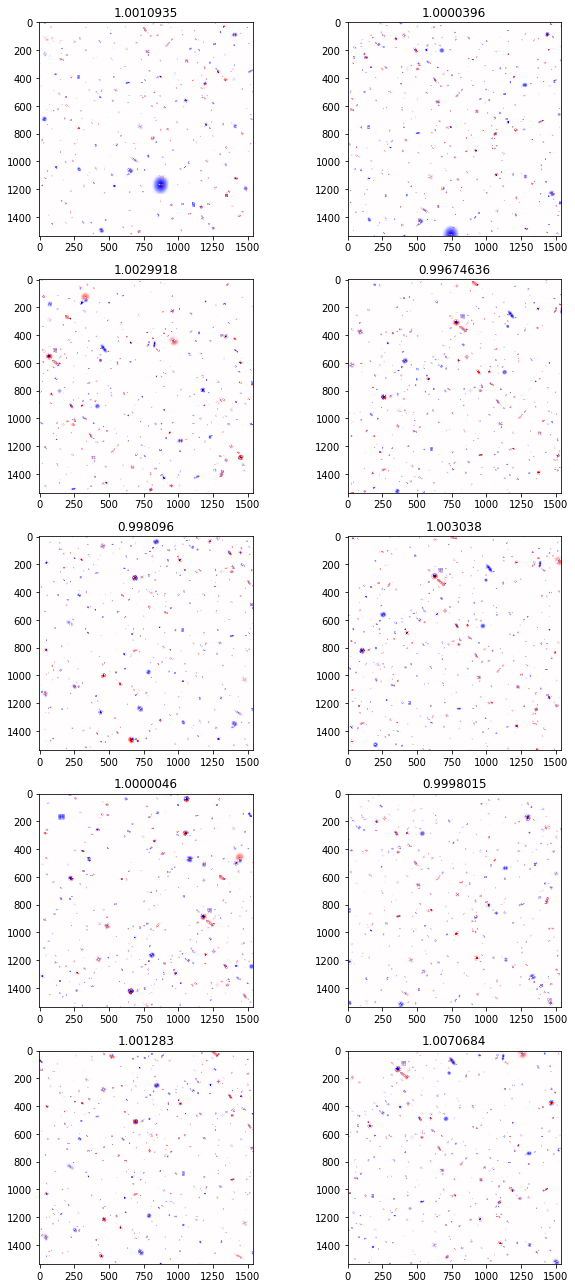

In [14]:
fig, axs = plt.subplots(nrows, ncols, figsize=(9,18))
diff_norm = colors.SymLogNorm(1, vmin=-1e5, vmax=1e5)
levmar_total_residual = 0
gsl_total_residual = 0

for i in range(nframes):
    levmar_residual = fits.open(os.path.join(levmar_dir, f'_residual_{i}.fits'))[0].data
    gsl_residual = fits.open(os.path.join(gsl_dir, f'_residual_{i}.fits'))[0].data
    levmar_total_residual += np.abs(levmar_residual).sum()
    gsl_total_residual += np.abs(gsl_residual).sum()
    ratio = np.abs(gsl_residual).sum() / np.abs(levmar_residual).sum()
    axs[int(i/2), int(i%2)].imshow(levmar_residual-gsl_residual, cmap=plt.get_cmap('seismic'), norm=diff_norm)
    axs[int(i/2), int(i%2)].set_title(ratio)

plt.tight_layout()
plt.show()

In [15]:
print(gsl_total_residual/levmar_total_residual)

1.0010621542586913


## Compare catalogs

In [16]:
levmar_cat = Table.read(os.path.join(levmar_dir, 'sim09_cat.fits'))
gsl_cat = Table.read(os.path.join(gsl_dir, 'sim09_cat.fits'))
sim09_r = Simulation('/home/aalvarez/Work/Data/sim09/sim09_r.list', mag_zeropoint=26, exposure=300)
sim09_r_img = Image('/home/aalvarez/Work/Data/sim09/sim09_r.fits', weight_image='/home/aalvarez/Work/Data/sim09/sim09_r.weight.fits')

In [17]:
print((np.isnan(levmar_cat['fmf_reduced_chi_2']) == np.isnan(gsl_cat['fmf_reduced_chi_2'])).all())
print(np.isclose(levmar_cat['auto_flux'], gsl_cat['auto_flux']).all())
print(np.isclose(levmar_cat['auto_flux_err'], gsl_cat['auto_flux_err']).all())

True
True
True


Filter out entries that have NaN $\chi^2$ or with a low signal/noise ratio (using iso aperture, which is the same for both)

In [18]:
nan_chi2 = np.isnan(levmar_cat['fmf_reduced_chi_2']) == False
signal_f = levmar_cat['isophotal_flux'] / levmar_cat['isophotal_flux_err'] > 10.
matching = np.logical_and(nan_chi2, signal_f)
levmar_cat = levmar_cat[matching]
gsl_cat = gsl_cat[matching]

print(len(gsl_cat))

844


In [19]:
crossval_r = CrossValidation(sim09_r_img, sim09_r, max_dist=1.5)

In [20]:
gsl_cross_r = crossval_r(gsl_cat['x'], gsl_cat['y'])
levmar_cross_r = crossval_r(levmar_cat['x'], levmar_cat['y'])

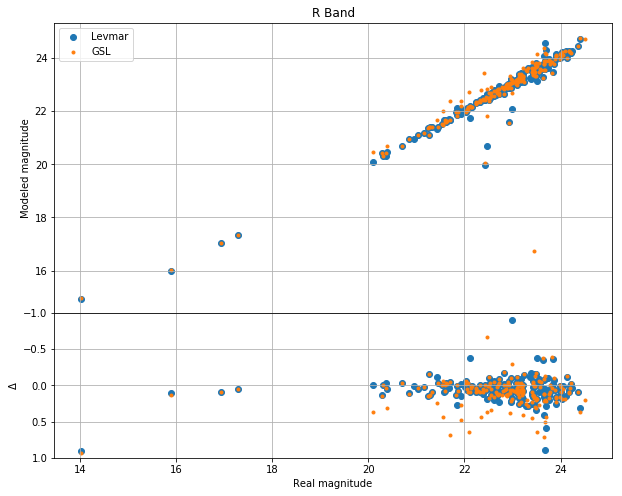

In [21]:
fig = plt.figure(figsize=(9, 8))
fig.subplots_adjust(left=0.07, right=0.93, hspace=0.0, wspace=0.2)
gridspec = GridSpec(3, 1)

ax_mag = fig.add_subplot(gridspec.new_subplotspec((0, 0), 2))
ax_mag.set_title('R Band')
ax_mag.set_ylabel('Modeled magnitude')
ax_mag.set_xlabel('Real magnitude')
ax_mag.scatter(levmar_cross_r.all_magnitudes, levmar_cat[levmar_cross_r.all_catalog]['mag'], label='Levmar', marker='o')
ax_mag.scatter(gsl_cross_r.all_magnitudes, gsl_cat[gsl_cross_r.all_catalog]['mag'], label='GSL', marker='.')
ax_mag.grid(True)
ax_mag.legend()

ax_diff = fig.add_subplot(gridspec.new_subplotspec((2, 0), 1))
ax_diff.set_ylabel('$\Delta$')
ax_diff.set_xlabel('Real magnitude')
ax_diff.scatter(levmar_cross_r.all_magnitudes, levmar_cat[levmar_cross_r.all_catalog]['mag'] - levmar_cross_r.all_magnitudes, label='Levmar', marker='o')
ax_diff.scatter(gsl_cross_r.all_magnitudes, gsl_cat[gsl_cross_r.all_catalog]['mag'] - gsl_cross_r.all_magnitudes, label='GSL', marker='.')
ax_diff.set_ylim(1, -1)
ax_diff.grid(True)

plt.show()

Text(0.5, 1.0, 'Aspect')

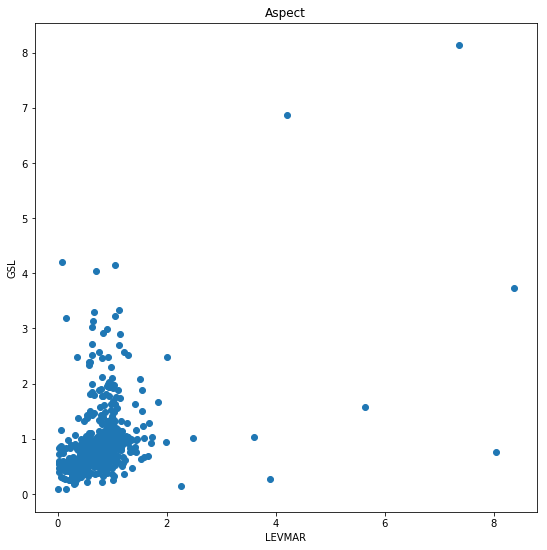

In [22]:
plt.figure(figsize=(9,9))
plt.scatter(levmar_cat['aspect'], gsl_cat['aspect'])
plt.xlabel('LEVMAR')
plt.ylabel('GSL')
plt.title('Aspect')

Text(0, 0.5, 'GSL')

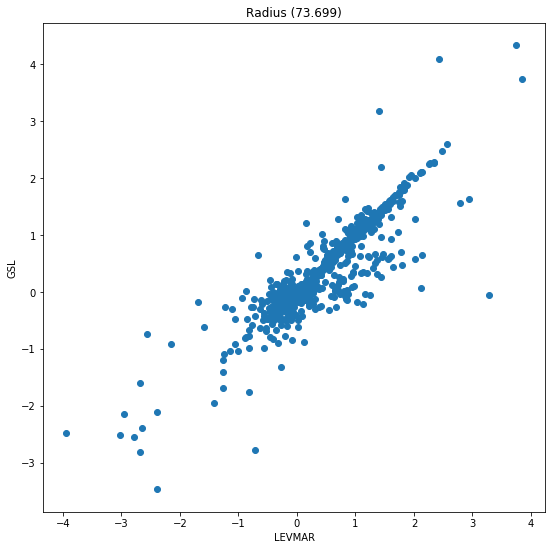

In [23]:
plt.figure(figsize=(9,9))
plt.scatter(np.log(levmar_cat['rad']), np.log(gsl_cat['rad']))
plt.title(
    'Radius ({:.3f})'.format(np.sqrt(((levmar_cat['rad'] - gsl_cat['rad'])**2).sum()))
)
plt.xlabel('LEVMAR')
plt.ylabel('GSL')

Text(0, 0.5, 'GSL')

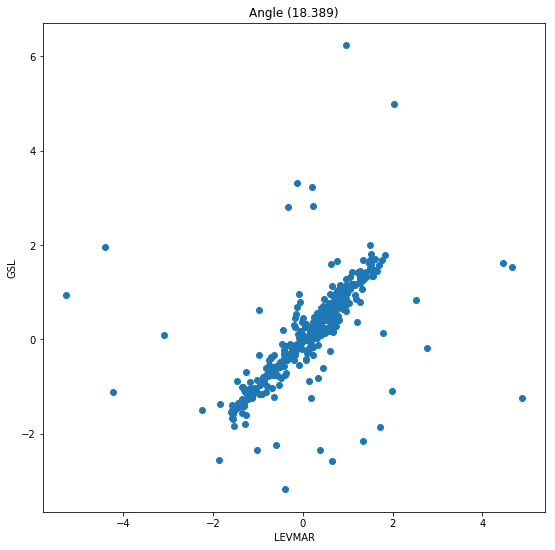

In [24]:
f = np.logical_or(
    np.logical_and(levmar_cat['aspect'] < 0.9, gsl_cat['aspect'] < 0.9),
    np.logical_and(levmar_cat['aspect'] > 1.1, gsl_cat['aspect'] > 1.1)
)
plt.figure(figsize=(9,9))
plt.scatter(levmar_cat['angle'][f], gsl_cat['angle'][f])
plt.title(
    'Angle ({:.3f})'.format(np.sqrt(((levmar_cat['angle'][f] - gsl_cat['angle'][f])**2).sum()))
)
plt.xlabel('LEVMAR')
plt.ylabel('GSL')

In [25]:
sim09_img = fits.open('/home/aalvarez/Work/Data/sim09/sim09_r.fits')[0].data

In [26]:
def render_models(fig, ax, catalog, **kwargs):
    patches = []
    for entry in catalog:
        patches.append(Ellipse((entry['x', 'y']), entry['rad']*2, entry['rad']*2*entry['aspect'], angle=np.degrees(-entry['angle']), **kwargs))
    col = PatchCollection(patches, alpha=0.5)
    col.set(array=np.log(catalog['flux']), cmap='inferno')
    ax.add_collection(col)
    ax.scatter(catalog['pixel_centroid_x'], levmar_cat['pixel_centroid_y'], marker='1', label='Detected', c='r')
    fig.colorbar(col, ax=ax)

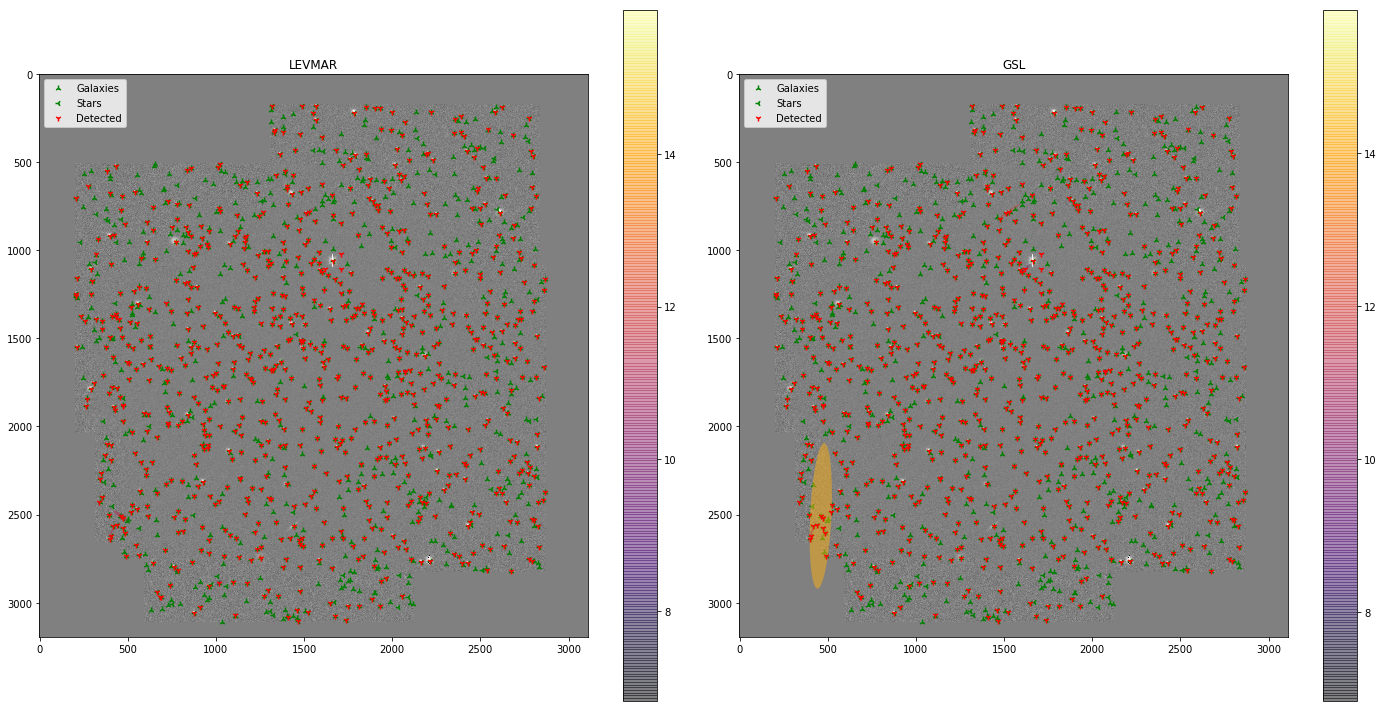

In [28]:
fig = plt.figure(figsize=(20, 10))
ax_levmar = plt.subplot(121)

ax_levmar.imshow(sim09_img, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(100))
ax_levmar.scatter(crossval_r.galaxies['x'], crossval_r.galaxies['y'], marker='2', label='Galaxies', c='green')
ax_levmar.scatter(crossval_r.stars['x'], crossval_r.stars['y'], marker='3', label='Stars', c='green')
render_models(fig, ax_levmar, levmar_cat)
ax_levmar.legend()
ax_levmar.set_title('LEVMAR')

ax_gsl = plt.subplot(122, sharex=ax_levmar, sharey=ax_levmar)
ax_gsl.imshow(sim09_img, cmap=plt.get_cmap('Greys_r'), norm=colors.SymLogNorm(100))
ax_gsl.scatter(crossval_r.galaxies['x'], crossval_r.galaxies['y'], marker='2', label='Galaxies', c='green')
ax_gsl.scatter(crossval_r.stars['x'], crossval_r.stars['y'], marker='3', label='Stars', c='green')
render_models(fig, ax_gsl, gsl_cat)
ax_gsl.legend()
ax_gsl.set_title('GSL')

plt.tight_layout()